[출처](https://www.datamanim.com/dataset/ADPpb/00/23.html)

## 1. 기계학습
- 데이터 설명

- 온,습도,조도,CO2농도에 따른 객실의 사용유무 판별
- 종속변수 Occupancy, 0: 비어있음 , 1: 사용중
- 데이터 출처 : https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+
- data Url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/p1/problem1.csv

### 1.1 데이터 EDA 수행 후, 분석가 입장에서 의미있는 탐색

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/23/problem1.csv')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.40,0.004773,1
1,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.75,0.004744,1
2,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.00,0.004767,1
3,2015-02-02 14:23:59,23.7600,26.260,568.666667,790.00,0.004779,1
4,2015-02-02 14:25:59,23.7540,26.290,509.000000,797.00,0.004783,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17910 entries, 0 to 17909
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17910 non-null  object 
 1   Temperature    17910 non-null  float64
 2   Humidity       17910 non-null  float64
 3   Light          17910 non-null  float64
 4   CO2            17889 non-null  float64
 5   HumidityRatio  17910 non-null  float64
 6   Occupancy      17910 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 979.6+ KB


In [4]:
df.shape

(17910, 7)

In [5]:
df.isna().sum()

date              0
Temperature       0
Humidity          0
Light             0
CO2              21
HumidityRatio     0
Occupancy         0
dtype: int64

In [6]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,17910.000000,17910.000000,17910.000000,17889.000000,17910.000000,17910.000000
mean,20.749036,27.589163,78.157369,647.700865,0.004175,0.117253
std,0.994012,5.043595,168.574068,285.997340,0.000755,0.321730
min,19.000000,16.745000,-99.000000,412.750000,0.002674,0.000000
25%,20.100000,24.390000,0.000000,453.000000,0.003702,0.000000
50%,20.600000,27.200000,0.000000,532.666667,0.004222,0.000000
75%,21.200000,31.290000,22.000000,722.000000,0.004790,0.000000
max,24.408333,39.500000,1581.000000,2076.500000,0.006461,1.000000


In [7]:
df.duplicated().sum()

0

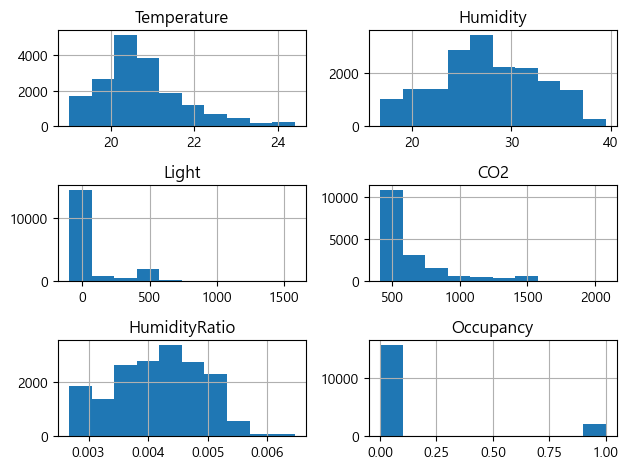

In [9]:
df.hist()
plt.tight_layout();

In [10]:
df.Occupancy.value_counts()

0    15810
1     2100
Name: Occupancy, dtype: int64

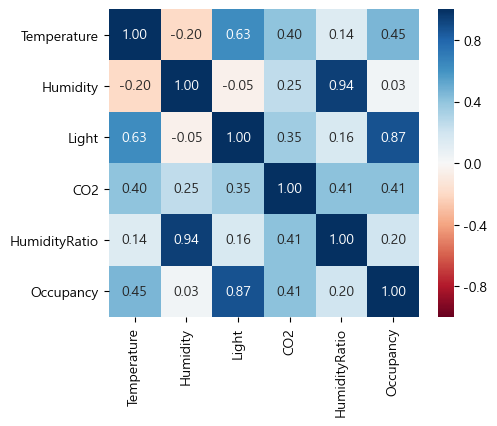

In [12]:
df_corr = df.corr()
plt.figure(figsize=(5,4))
sns.heatmap(df_corr, fmt='.2f', cmap='RdBu', vmax=1, vmin=-1, annot=True);

1. 결측치 존재 여부
    - CO2 변수에만 결측치가 있다. 수치형 변수이므로 평균 또는 중앙값으로 대체할 수 있다.
1. 데이터 타입
    - 종속변수인 Occupancy는 0 또는 1로 이루어져 있고, int형으로 구성되어 있다. 독립변수는 object와 float로 구성되어 있다.
1. 종속변수와 독립변수의 상관관계
    - 상관성이 가장 높은 관계는 Occupancy와 Light로 상관계수는 0.84로 나타났다.
1. 독립변수 간 상관관계
    - 다중공선성을 의심할 만큼 상관성이 높은 관계는 HumidityRatio와 Humidity로 이때 상관계수는 0.94로 나타났다.
    - 따라서 두 변수 간의 관계는 주의해야 할 필요가 있다.
1. 유의할 점
    - 종속변수의 클래스 개수가 불균형하다.
    - 0 값이 15810개 1값이 2100개로 데이터 불균형 이슈가 우려되므로 오버샘플링 또는 언더샘플링 기법을 사용해야 할 것으로 판단한다.

### 1.2 결측치를 대체하는 방식 선택하고 근거제시, 대체 수행
- 결측치를 대체하는 방식에는 단순 대치법과 KNN을 이용한 결측치 대체가 있다.
- 단순 대치법: 수치형 변수라면 각 컬럼의 평균이나 중앙값을 사용하여 결측치를 대체할 수 있지만 범주형 변수라면 최빈값을 이용할 수 있다.
- KNN을 이용한 결측치 대체: 보간법 중 결측치가 없는 컬럼들의 최근접 이웃 알고리즘을 통해 결측치가 있는 변수를 대체할 수 있다. 단 거리 계산이 가능한 수치형 변수만 사용 가능하다.
- 본 분석에서는 빠른 처리를 위해 단순 대치법을 이용하며, 그중에서도 평균값으로 대체할 것이다.

In [16]:
df.fillna(df.mean(), inplace=True)
df.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

### 1.3 추가적으로 데이터의 질 및 품질관리를 향상시킬만한 내용 작성
1. Light의 최솟값이 -99인 것으로 보아 결측값인 것으로 판단된다. 따라서 해당 값을 Light의 평균값으로 바꿀 수 있다.
1. 수치형 변수들의 값의 단위가 다르므로 스케일링을 통해 이들의 범위를 동일하게 할 필요가 있다. 

In [19]:
df.loc[df['Light']==-99, 'Light'] = np.mean(df['Light'])
np.min(df['Light'])

0.0

### 2.1 데이터에 불균형이 있는지 확인, 불균형 판단 근거 작성
- 0 값이 15810개 1값이 2100개로 데이터 불균형 이슈가 우려되므로 오버샘플링 또는 언더샘플링 기법을 사용해야 할 것으로 판단한다.

In [20]:
df.Occupancy.value_counts()

0    15810
1     2100
Name: Occupancy, dtype: int64

### 2.2 오버샘플링 방법들 중 2개 선택하고 장단점 등 선정 이유 

In [30]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
X = df.drop(['date', 'Occupancy'], axis=1)
y = df.Occupancy

ro = RandomOverSampler(random_state=1)
X_ro, y_ro = ro.fit_resample(X, y)

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

print('랜덤오버샘플링:\n', pd.Series(y_ro).value_counts())
print()
print('SMOTE:\n', pd.Series(y_sm).value_counts())

랜덤오버샘플링:
 1    15810
0    15810
dtype: int64

SMOTE:
 1    15810
0    15810
dtype: int64


### 3.1 속도측면, 정확도측면 모델 1개씩 선택, 선택 이유도 기술
- 이진 분류이므로 속도 측면에서는 로지스틱 회귀모델을 선택하였고, 정확도 측면에서는 램덤포레스트를 선택하였다.
- 로지스틱 회귀모델을 선택한 이유는 분류 모델에서 널리 사용되는 이진 분류기이며, 모델 속도가 다른 분류 모델에 비해 빠른 편이기에 선택하였다.
- 랜덤포레스트는 앙상블 기법 중 하나로 배깅, 부스팅보다 더 많은 무작위성을 주어 약한 학습기를 생성한 후에 이를 선형결합하여 최종 학습기를 만드는 모델이다. 따라서 정확도 측면에서 보장할 수 있는 성능을 보이기에 선택하였다.

### 3.2 위에서 오버샘플링 한 데이터 2개, 오버샘플링 하기 전 데이터 1개에 대해 모델 2개를 적용하고 성능 보여주기

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn.preprocessing import StandardScaler

X = df.drop(['date', 'Occupancy'], axis=1)
y = df.Occupancy

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.3, random_state=1)

# 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

lr = LogisticRegression()
rfr_clf = RandomForestClassifier()

# 모델 구현
def make_model(model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return print(f'<{model.__class__.__name__}>\n time: {round(end-start, 4)}sec / 정확도: {round(acc, 4)}')
print('--오버 샘플링 전--')
make_model(lr, X_train_sc, y_train, X_test_sc, y_test)
make_model(rfr_clf, X_train_sc, y_train, X_test_sc, y_test)

--오버 샘플링 전--
<LogisticRegression>
 time: 0.0873sec / 정확도: 0.9883
<RandomForestClassifier>
 time: 1.3123sec / 정확도: 0.9948


In [60]:
# 랜덤 오버샘플링
X_train_ro, X_test_ro, y_train_ro, y_test_ro =  train_test_split(X_ro, y_ro, test_size=.3, random_state=1)

# 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_ro)
X_test_sc = scaler.transform(X_test_ro)

# 모델 구현
def make_model_over(model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return print(f'<{model.__class__.__name__}>\n time: {round(end-start, 4)}sec / 정확도: {round(acc, 4)}')
print('--랜덤 오버 샘플링--')
make_model_over(lr, X_train_sc, y_train_ro, X_test_sc, y_test_ro)
make_model_over(rfr_clf, X_train_sc, y_train_ro, X_test_sc, y_test_ro)

--랜덤 오버 샘플링--
<LogisticRegression>
 time: 0.1135sec / 정확도: 0.9897
<RandomForestClassifier>
 time: 2.4648sec / 정확도: 0.9974


In [63]:
# SMOTE
X_train_sm, X_test_sm, y_train_sm, y_test_sm =  train_test_split(X_sm, y_sm, test_size=.3, random_state=1)

# 스케일링
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_sm)
X_test_sc = scaler.transform(X_test_sm)

# 모델 구현
print('--SMOTE--')
make_model_over(lr, X_train_sc, y_train_sm, X_test_sc, y_test_sm)
make_model_over(rfr_clf, X_train_sc, y_train_sm, X_test_sc, y_test_sm)

--SMOTE--
<LogisticRegression>
 time: 0.0918sec / 정확도: 0.9898
<RandomForestClassifier>
 time: 3.5107sec / 정확도: 0.996


### 3.3 위 예측결과 사용해서 오버샘플링이 미친 영향에 대해 작성하라

- 오버샘플링을 적용한 모델은 원본 데이터를 이용한 모델보다 학습 속도가 더 오래 걸린 것을 알 수 있다. 이는 오버샘플링으로 데이터 수가 증가했기 때문이라고 유추할 수 있다.
- 또한 랜덤포레스트보다 로지스틱귀 모델의 속도가 더 빠른 것이 공통적으로 나타났다.
- 모델 성능은 큰 차이는 없지만 전반적으로 향상되었다. 원본 데이터를 이용한 각 모델의 정확도는 0.9883, 0.9948이었다면, 랜덤 오버 샘플링을 이용한 모델의 정확도는 0.9897, 0.9974, SMOTE는 각각 0.9898, 0.996이었다.
- 따라서 오버 샘플링이 분석 정확도에 긍정적인 영향을 주었다는 것을 알 수 있다. 특히 오버 샘플링은 데이터 불균형으로 인한 과적합을 방지하고, 예측 모델의 일반화를 가능하게 하였다.

## 2. 통계분석

- 공장에서는 진공관 수명이 1만 시간이라고 주장하여 품질관리팀에서 12개 샘플을 뽑았음 유의수준 5%에서 부호 검정하시오

### 2.1 귀무가설, 연구가설 세우기
- 귀무가설: 진공관 수명은 1만 시간이다.
- 대립가설: 진공관 수명은 1만 시간이 아니다.

### 2.2 유효한 데이터의 개수는?

In [64]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/23/problem2.csv')
df.head()

,name,life span
0,sample1,10000
1,sample2,9000
2,sample3,9500
3,sample4,10000
4,sample5,10000


In [66]:
print('중위수와 동일한 값들은 순위 부호 검정에서 불필요한 데이터이다. 그 숫자는 : ',
      df[df['life span']==np.median(df['life span'])].shape[0])

df_fillter = df[df['life span'] != 10000]

print(f'유효한 데이터 개수: {len(df_fillter)}')

중위수와 동일한 값들은 순위 부호 검정에서 불필요한 데이터이다. 그 숫자는 :  4
유효한 데이터 개수: 8


### 2.3 검정통계량 및 연구가설 채택 여부를 작성하라

In [69]:
import scipy.stats as stats
stats.shapiro(df['life span']) # 정규성 만족 못 함

ShapiroResult(statistic=0.7996643781661987, pvalue=0.00928695872426033)

In [82]:
stats.wilcoxon(df['life span'] - 10_000) # 귀무가설 채택

WilcoxonResult(statistic=8.5, pvalue=0.18289327757982765)

# 3. 코로나 시계열 데이터
- 일자/국가명/확진자수
- 데이터 출처(후처리과정 미포함) :https://www.kaggle.com/antgoldbloom/covid19panels?select=country_panel.csv 
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/p1/problem3_covid2.csv

In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/23/problem3_covid2.csv')
df.head()

,location,date,new_cases
0,Austria,2021-01-01,2096.0
1,Austria,2021-01-02,1391.0
2,Austria,2021-01-03,1466.0
3,Austria,2021-01-04,1642.0
4,Austria,2021-01-05,2311.0


### 3.1 데이터는 일자별 각 나라의 일일 확진자수를 나타낸다. 각 나라의 일자별 누적확진자 수를 나타내는 데이터 프레임을 생성하라

In [3]:
df.shape

(11895, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11895 entries, 0 to 11894
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   11895 non-null  object 
 1   date       11895 non-null  object 
 2   new_cases  11662 non-null  float64
dtypes: float64(1), object(2)
memory usage: 278.9+ KB


In [8]:
df['date'] = pd.to_datetime(df['date'])

In [22]:
target = df.groupby(['location', 'date']).sum().groupby(level=0).cumsum()
target.columns = ['cumulative sum']
target = target.reset_index()
target

,location,date,cumulative sum
0,Austria,2021-01-01,2096.0
1,Austria,2021-01-02,3487.0
2,Austria,2021-01-03,4953.0
3,Austria,2021-01-04,6595.0
4,Austria,2021-01-05,8906.0
...,...,...,...
11890,Vanuatu,2021-10-28,5.0
11891,Vanuatu,2021-10-29,5.0
11892,Vanuatu,2021-10-30,5.0
11893,Vanuatu,2021-10-31,5.0


### 3.2 1에서 구한 데이터를 각 나라별로 acf값을 구하고(lag는 50개까지 구하고 첫번째 값을 제외하라) 국가를 기준으로 유클리디안 거리를 기준으로 클러스터링을 진행 후 계층적 군집 분석을 위해 덴드로그램 작성하라

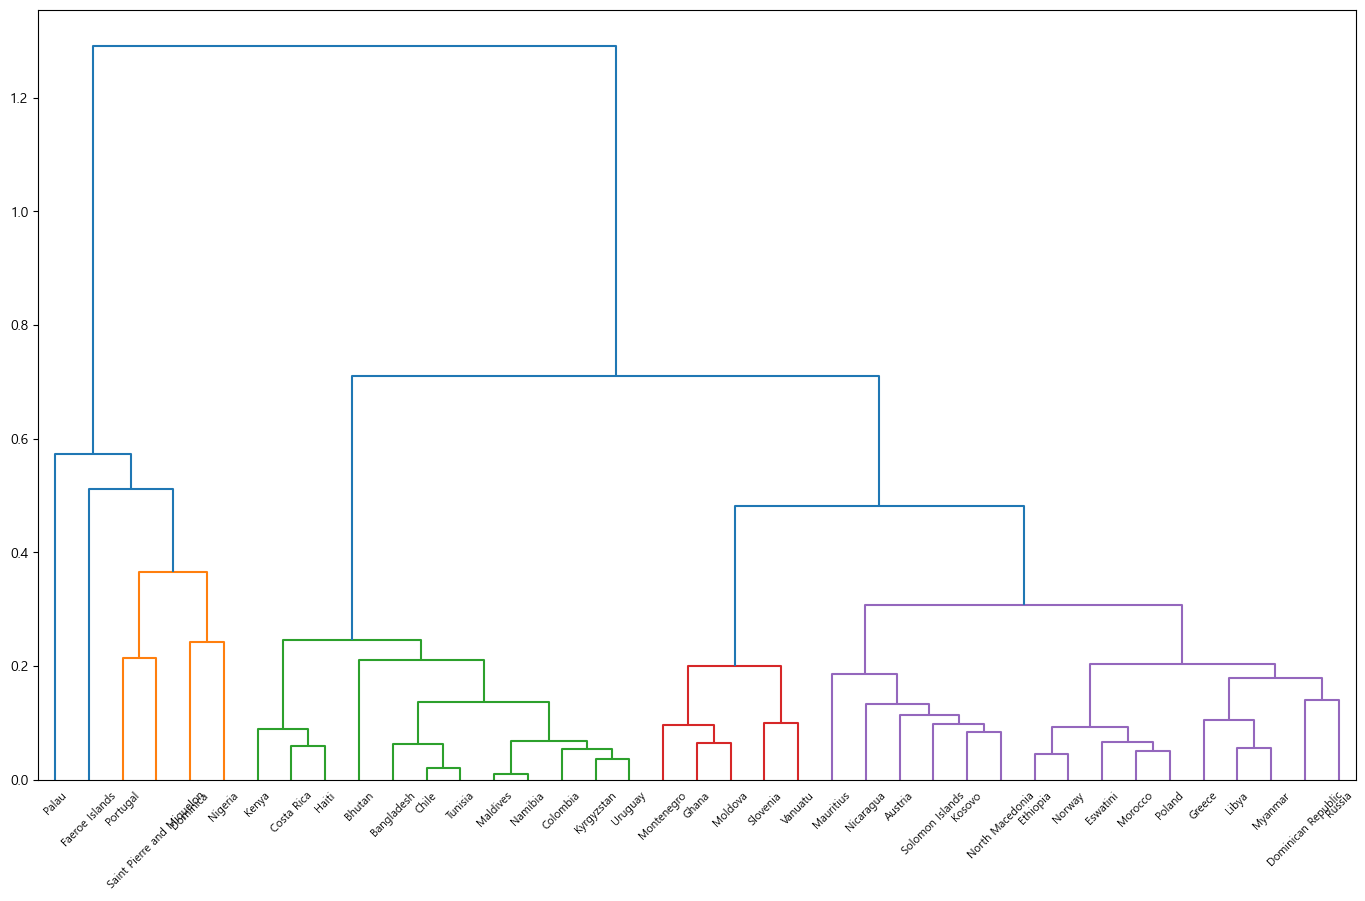

In [24]:
from scipy.spatial import distance
import statsmodels.api as sm
import numpy as np
name =[]
for lo in target.location.unique(): # 나라별로 for문 돌리기
    
    # ACF 계산
    v = sm.tsa.stattools.acf(target[target.location==lo]['cumulative sum'], nlags=50, fft=False) 
    name.append([lo]+list(v[1:]))

v = pd.DataFrame(name)

import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

data =v.set_index(0)
label = np.array(data.index)

datav = data.values

fig = plt.figure(figsize=(17,10))

ax3 = fig.add_subplot(1,1,1)
dend3 = linkage(datav, method='average', metric='euclidean')
cutoff = 0.3*max(dend3[:,2])
dend_res3 = dendrogram(dend3, color_threshold=cutoff)
ax3.set_xticklabels(label[dend_res3['leaves']], minor=False)

plt.show()

## 4. 아래 이미지와 같은 학과별 학점 분포 인원수 표가 있다. 학과와 성적이 관계있는지를 검정하라
### 4.1 귀무가설, 연구가설 세우기
- 귀무가설: 학과와 성적은 서로 독립이다.
- 대립가설: 학과와 성적은 서로 독립이 아니다.

### 4.2 학과와 성적이 독립일 경우의 기댓값을 구하시오
### 4.3 검정통계량 구하고 연구가설의 채택여부 작성 

In [32]:
tab = pd.DataFrame({'사회과학': [15, 60, 24], '자연과학': [25, 69, 5], '공학': [10, 77, 13]},
                  index= ['1.5~2.5', '2.5~3.5', '3.5~4.5'])
tab

,사회과학,자연과학,공학
1.5~2.5,15,25,10
2.5~3.5,60,69,77
3.5~4.5,24,5,13


In [34]:
from scipy.stats import chi2_contingency
chi, p, df, expect = chi2_contingency(tab)
print('p-value: ', p) # 독립이 아님
print('기댓값: ', expect)

p-value:  0.00018822647762421383
기댓값:  [[16.61073826 16.61073826 16.77852349]
 [68.43624161 68.43624161 69.12751678]
 [13.95302013 13.95302013 14.09395973]]
